In [1]:
# Imports necessários para TFT (PyTorch Forecasting)
# Tenta instalar automaticamente pacotes ausentes
import sys, subprocess, importlib

def ensure_any(mod_name: str, pip_candidates: list[str]):
    try:
        return importlib.import_module(mod_name)
    except Exception:
        last_err = None
        for candidate in pip_candidates:
            try:
                subprocess.check_call([sys.executable, "-m", "pip", "install", candidate, "-q"])  # instala silenciosamente
                return importlib.import_module(mod_name)
            except Exception as e:
                last_err = e
        raise last_err if last_err else ImportError(f"Falha ao instalar {mod_name}")

# Garantir dependências principais (sem TimesFM)
ensure_any('torch', ['torch'])
ensure_any('pytorch_forecasting', ['pytorch-forecasting'])
ensure_any('pytorch_lightning', ['pytorch-lightning'])

# Importa libs
import torch
import pytorch_forecasting as ptf
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.metrics import QuantileLoss
from pytorch_lightning import Trainer

c:\Users\victo\AppData\Local\Programs\Python\Python313\Lib\site-packages\pytorch_forecasting\models\base\_base_model.py:28: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


# Predição de séries temporais de carga elétrica

Este notebook coleta, organiza e visualiza dados públicos da ENTSO‑E para construir conjuntos de treino e avaliação de modelos de previsão temporal. O foco atual está em carga realizada e preços de energia (A65 e A44) para países europeus selecionados.

Autor: Victor Mario Bertini (RA: 194761)

# Etapa 1 — Coleta de dados

Nesta etapa baixamos dados da ENTSO‑E via API REST e salvamos em formato Parquet dentro da pasta `data/`. O objetivo é permitir reexecuções parciais: cada subetapa persiste artefatos para evitar refazer todo o fluxo.

Fonte: https://transparency.entsoe.eu/content/static_content/Static%20content/web%20api/Guide.html

Escopo desta versão do notebook:
- Países europeus selecionados (DE, FR, IT, ES, PT, CZ, NL, BE, AT, PL)
- Datasets principais:
  - Load — Actual Total (carga realizada agregada)
  - Market — Energy Prices (preços de energia)
- Período: até 180 dias retroativos

Subcapítulos desta etapa:
1. Coleta e salvamento bruto (Parquet)
2. Visualização exploratória (carga e preço)
3. Preparação de dados para treino

## Dependências

In [2]:
# Checagem/instalação leve de dependências
print("Verificando dependências (pyarrow para Parquet)...")

try:
    import pyarrow as pa
    print(f"PyArrow disponível: {pa.__version__}")
except Exception:
    print("Instalando pyarrow...")
    !pip install --upgrade "pyarrow>=18" --quiet
    import importlib
    importlib.invalidate_caches()
    import pyarrow as pa
    print(f"PyArrow instalado: {pa.__version__}")

# fastparquet é opcional
try:
    import fastparquet  # noqa: F401
    print("fastparquet disponível (opcional)")
except Exception:
    pass

# Outras bibliotecas sob demanda
for lib in [
    "numpy", "python-dotenv", "pandas", "matplotlib", "seaborn",
    "scikit-learn", "tensorflow", "keras", "lxml", "pytz", "requests"
]:
    try:
        __import__(lib)
    except ImportError:
        print(f"Instalando {lib}...")
        !pip install {lib} --quiet

print("Dependências prontas")

Verificando dependências (pyarrow para Parquet)...
PyArrow disponível: 21.0.0
fastparquet disponível (opcional)
Instalando python-dotenv...
fastparquet disponível (opcional)
Instalando python-dotenv...
Instalando scikit-learn...
Instalando scikit-learn...
Dependências prontas
Dependências prontas


## Capítulo 1 — Coleta de dados brutos

### Imports

In [3]:
# Imports para a API e utilidades
import os
import requests
import pandas
from dotenv import load_dotenv
from datetime import datetime, timedelta, date
import pytz

# Carregar variáveis de ambiente do .env
load_dotenv()

True

### Definição de funções de coleta de dados e de salvamento em parquet

In [4]:
import os
import re
import time
from datetime import datetime, timedelta
from concurrent.futures import ThreadPoolExecutor, as_completed

import pandas as pd
import requests
from lxml import etree

# ---------------- CONFIG ---------------- #
COUNTRY_DOMAINS = {
    "FR": {"domain": "10YFR-RTE------C"},
    "ES": {"domain": "10YES-REE------0"},
    "PT": {"domain": "10YPT-REN------W"},
    "CZ": {"domain": "10YCZ-CEPS-----N"},
    "NL": {"domain": "10YNL----------L"},
    "BE": {"domain": "10YBE----------2"},
    "PL": {"domain": "10YPL-AREA-----S"},
}

DATA_ITEMS = [
    {'key': 'load_total', 'documentType': 'A65', 'processType': 'A16', 'domainParam': 'outBiddingZone_Domain', 'parser': 'load'},
    {'key': 'market_prices', 'documentType': 'A44', 'processType': 'A07', 'domainParamIn': 'in_Domain', 'domainParamOut': 'out_Domain', 'parser': 'price'}
]

ENTSOE_TOKEN = os.environ.get("ENTSOE_SECURITY_TOKEN")
BASE_URL = "https://web-api.tp.entsoe.eu/api"
MAX_WORKERS = 100
RAW_DIR = os.path.join("data", "raw")
PARQUET_COMPRESSION = "zstd"
os.makedirs(RAW_DIR, exist_ok=True)

# ---------------- HELPERS ---------------- #
def build_params(item, domain, start_dt, end_dt):
    """Build API query parameters."""
    return {
        "securityToken": ENTSOE_TOKEN,
        "documentType": item['documentType'],
        "periodStart": start_dt.strftime("%Y%m%d%H%M"),
        "periodEnd": end_dt.strftime("%Y%m%d%H%M"),
        **({"processType": item['processType']} if item.get('processType') else {}),
        **({item['domainParamIn']: domain, item['domainParamOut']: domain} if item.get('domainParamIn') else {item.get('domainParam'): domain})
    }

def parse_xml_points(xml_bytes: bytes, parser_type: str) -> pd.DataFrame:
    """Parse ENTSO-E XML response into a DataFrame with proper datetime."""
    root = etree.fromstring(xml_bytes)
    period_elem = root.find(".//{*}Period")
    if period_elem is None:
        return pd.DataFrame()

    start_elem = period_elem.find("{*}timeInterval/{*}start")
    period_start = start_elem.text if start_elem is not None else None

    res_elem = period_elem.find("{*}resolution")
    resolution = res_elem.text if res_elem is not None else None

    rows = []
    for point in period_elem.findall("{*}Point"):
        pos_elem = point.find("{*}position")
        if pos_elem is None or pos_elem.text is None:
            continue
        pos = int(pos_elem.text)

        if parser_type == "load":
            val_elem = point.find("{*}quantity")
            if val_elem is None or val_elem.text is None:
                continue
            rows.append({
                'position': pos,
                'quantity_MW': float(val_elem.text),
                'period_start': period_start,
                'resolution': resolution
            })
        elif parser_type == "price":
            val_elem = point.find("{*}price.amount")
            if val_elem is None or val_elem.text is None:
                continue
            rows.append({
                'position': pos,
                'price_EUR_MWh': float(val_elem.text),
                'period_start': period_start,
                'resolution': resolution
            })

    df = pd.DataFrame(rows)
    
    if not df.empty and 'period_start' in df.columns and 'resolution' in df.columns:
        # extract minutes from resolution string (positions 2:4)
        df['minutes'] = df['resolution'].str[2:4].astype(int)
        df['datetime'] = pd.to_datetime(df['period_start'], utc=True) + pd.to_timedelta((df['position'] - 1) * df['minutes'], unit='minutes')
        df.drop(columns=['minutes'], inplace=True)
    
    return df

def fetch_day(session, item, country, day: datetime, retries=3, delay=5):
    """Fetch a single day of data for a given country and item."""
    domain = COUNTRY_DOMAINS[country]['domain']
    start_dt = day
    end_dt = start_dt + timedelta(days=1)
    params = build_params(item, domain, start_dt, end_dt)

    for attempt in range(retries):
        try:
            r = session.get(BASE_URL, params=params, timeout=30)
            r.raise_for_status()
            df = parse_xml_points(r.content, item['parser'])
            if df.empty:
                return pd.DataFrame()
            df['country'] = country
            return df
        except (requests.exceptions.RequestException, etree.XMLSyntaxError) as e:
            print(f"[WARNING] Attempt {attempt+1} failed for {country} {item['key']} {day}: {e}")
            time.sleep(delay * (2 ** attempt))
    return pd.DataFrame()

def daterange(start: datetime, end: datetime):
    """Yield datetime objects for each day between start and end, inclusive of start, exclusive of end."""
    current = start
    while current < end:
        yield current
        current += timedelta(days=1)

def fetch_last_days(lookback_days: int, reference_datetime: datetime = None) -> pd.DataFrame:
    """
    Fetch ENTSO-E data for the last `lookback_days` days, rounding reference time down to the previous full hour.
    """
    if reference_datetime is None:
        reference_datetime = datetime.now()

    # Round down to previous hour
    end_dt = reference_datetime.replace(minute=0, second=0, microsecond=0)
    start_dt = end_dt - timedelta(days=lookback_days)

    print(f"[INFO] Fetching data from {start_dt} to {end_dt} (rounded to hour)")

    all_dfs = []
    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        futures = []
        with requests.Session() as session:
            for item in DATA_ITEMS:
                for country in COUNTRY_DOMAINS:
                    for single_day in daterange(start_dt, end_dt):
                        futures.append(executor.submit(fetch_day, session, item, country, single_day))
            for f in as_completed(futures):
                df = f.result()
                if not df.empty:
                    all_dfs.append(df)

    if all_dfs:
        merged = pd.concat(all_dfs, ignore_index=True)
        merged = merged.pivot_table(index=['datetime', 'country'],
                                    values=['quantity_MW', 'price_EUR_MWh'],
                                    aggfunc='first').reset_index()
        merged['quantity_MW'] = merged.groupby('country')['quantity_MW'].ffill()
        merged['price_EUR_MWh'] = merged.groupby('country')['price_EUR_MWh'].ffill()

        filename = f"raw_dataset.parquet"
        path = os.path.join(RAW_DIR, filename)
        merged.to_parquet(path, engine="pyarrow", compression=PARQUET_COMPRESSION, index=False)
        print(f"[INFO] Saved merged data to {path}")
        return merged
    else:
        return pd.DataFrame(columns=['datetime', 'country', 'quantity_MW', 'price_EUR_MWh'])



## Coletando dados

Nesta seção vamos buscar dados históricos de carga (A65) e preços de energia (A44). O período é exclusivamente passado (até ontem):
- Carga (A65): outBiddingZone_Domain = <EIC do país>
- Preços de energia (A44): in_Domain = <EIC do país> e out_Domain = <EIC do país>

Os resultados serão salvos como arquivos Parquet em `data/` para reutilização nas próximas etapas.

In [5]:
lookback_days = 30
df = fetch_last_days(lookback_days)

[INFO] Fetching data from 2025-09-24 15:00:00 to 2025-10-24 15:00:00 (rounded to hour)
[WARNING] Attempt 1 failed for FR load_total 2025-09-27 15:00:00: HTTPSConnectionPool(host='web-api.tp.entsoe.eu', port=443): Max retries exceeded with url: /api?securityToken=89e296f4-6b1d-4276-a141-290239d0a1ed&documentType=A65&periodStart=202509271500&periodEnd=202509281500&processType=A16&outBiddingZone_Domain=10YFR-RTE------C (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x00000248C876D450>, 'Connection to web-api.tp.entsoe.eu timed out. (connect timeout=30)'))
[WARNING] Attempt 1 failed for FR load_total 2025-10-01 15:00:00: HTTPSConnectionPool(host='web-api.tp.entsoe.eu', port=443): Max retries exceeded with url: /api?securityToken=89e296f4-6b1d-4276-a141-290239d0a1ed&documentType=A65&periodStart=202510011500&periodEnd=202510021500&processType=A16&outBiddingZone_Domain=10YFR-RTE------C (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0

In [6]:
print(df.head())
print(df.tail())

                   datetime country  price_EUR_MWh  quantity_MW
0 2025-09-23 22:00:00+00:00      BE          73.40          NaN
1 2025-09-23 22:00:00+00:00      CZ          75.64          NaN
2 2025-09-23 22:00:00+00:00      ES          53.51          NaN
3 2025-09-23 22:00:00+00:00      FR           0.00          NaN
4 2025-09-23 22:00:00+00:00      NL          82.08          NaN
                       datetime country  price_EUR_MWh  quantity_MW
19508 2025-10-24 14:45:00+00:00      CZ          61.36       7935.0
19509 2025-10-24 14:45:00+00:00      ES          64.00      27168.0
19510 2025-10-24 14:45:00+00:00      FR          17.59      48176.0
19511 2025-10-24 14:45:00+00:00      NL          51.78       9772.0
19512 2025-10-24 14:45:00+00:00      PL         107.20      21684.0


## Visualização dos dados

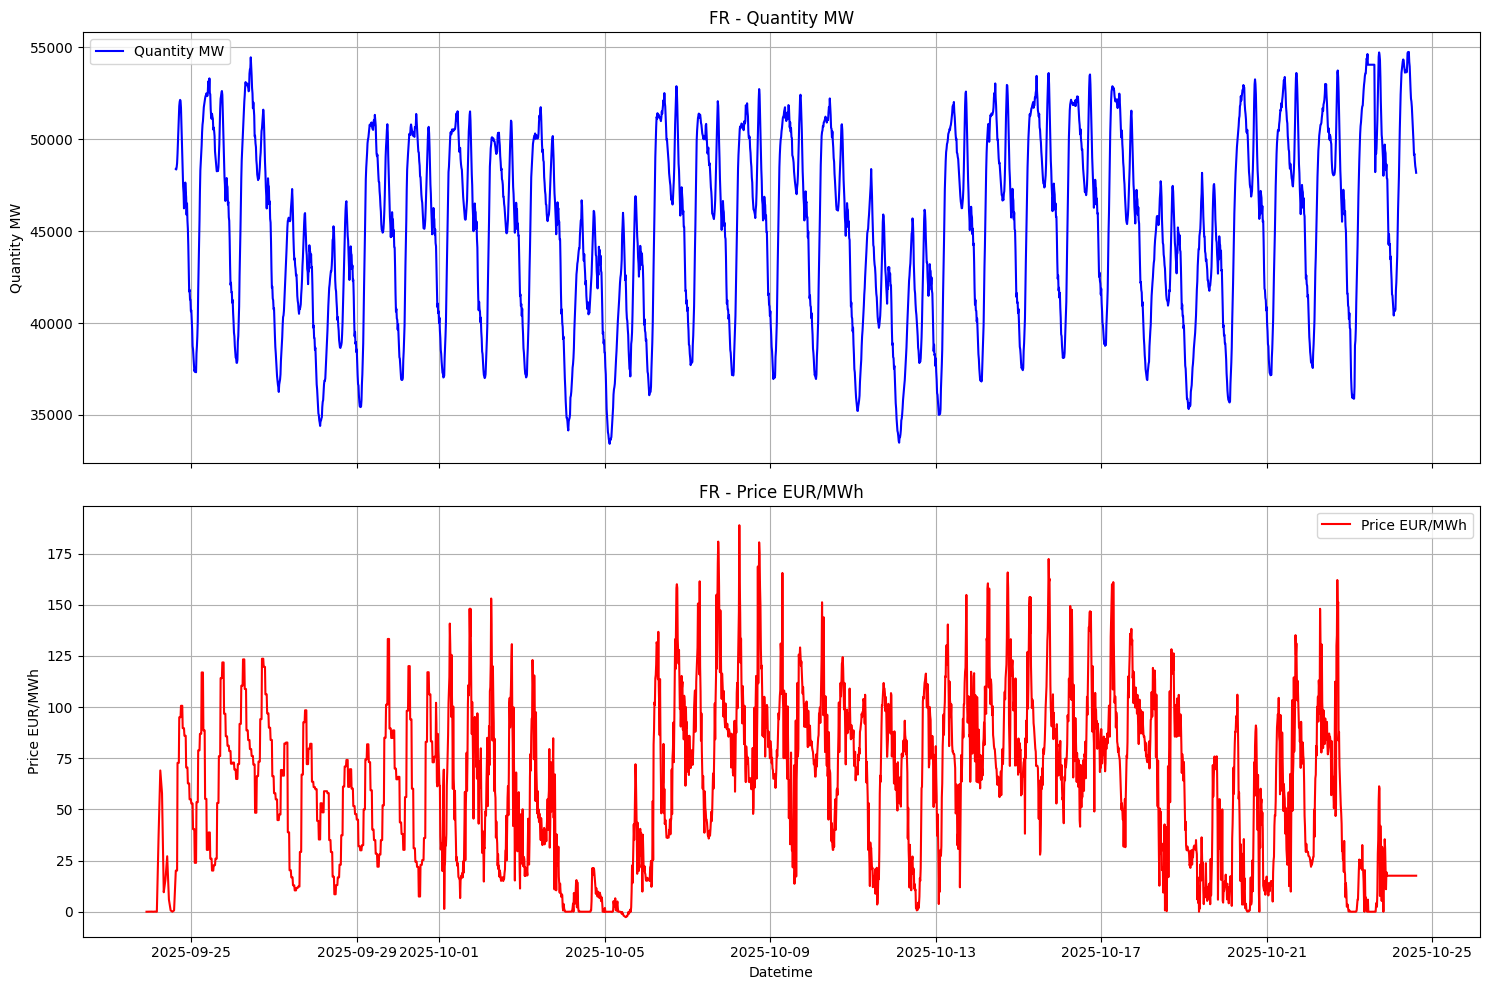

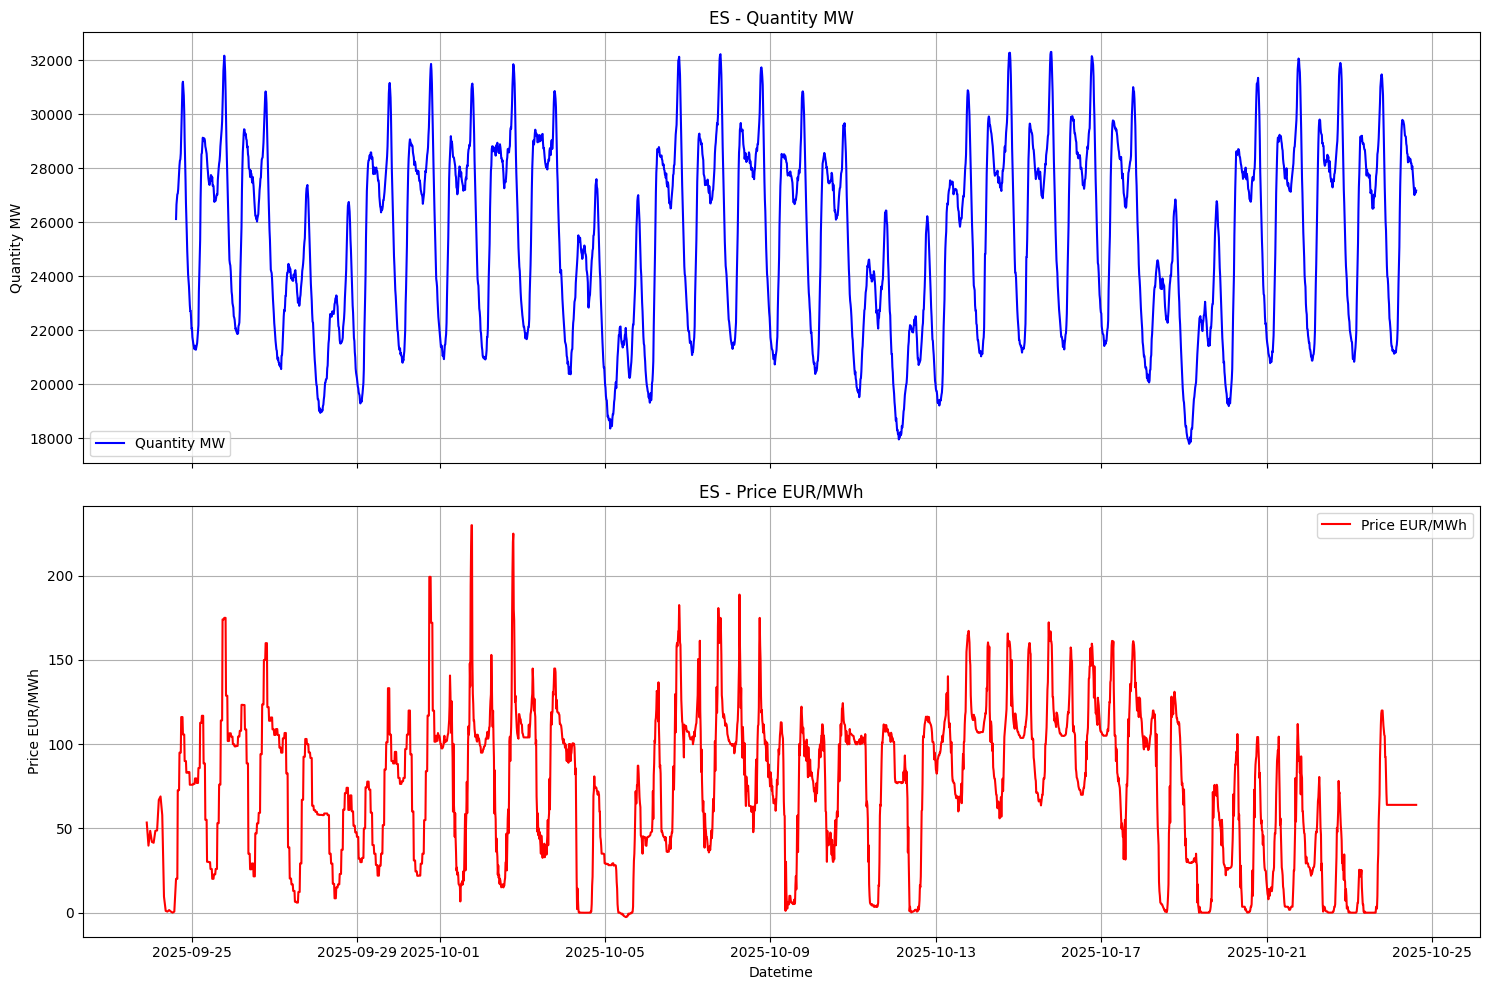

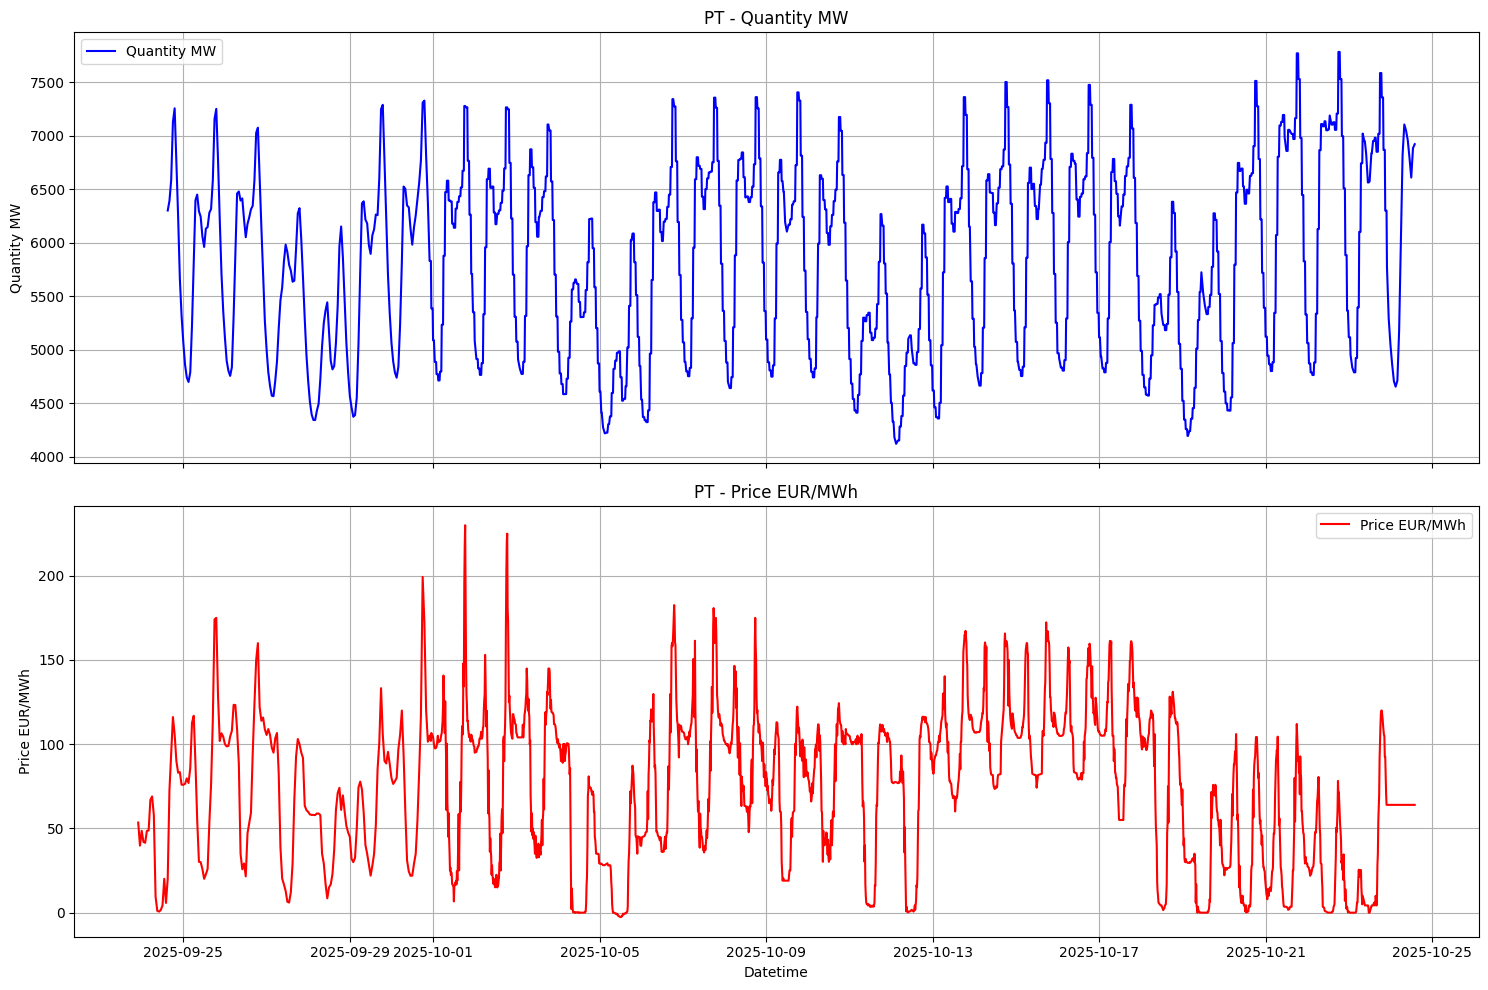

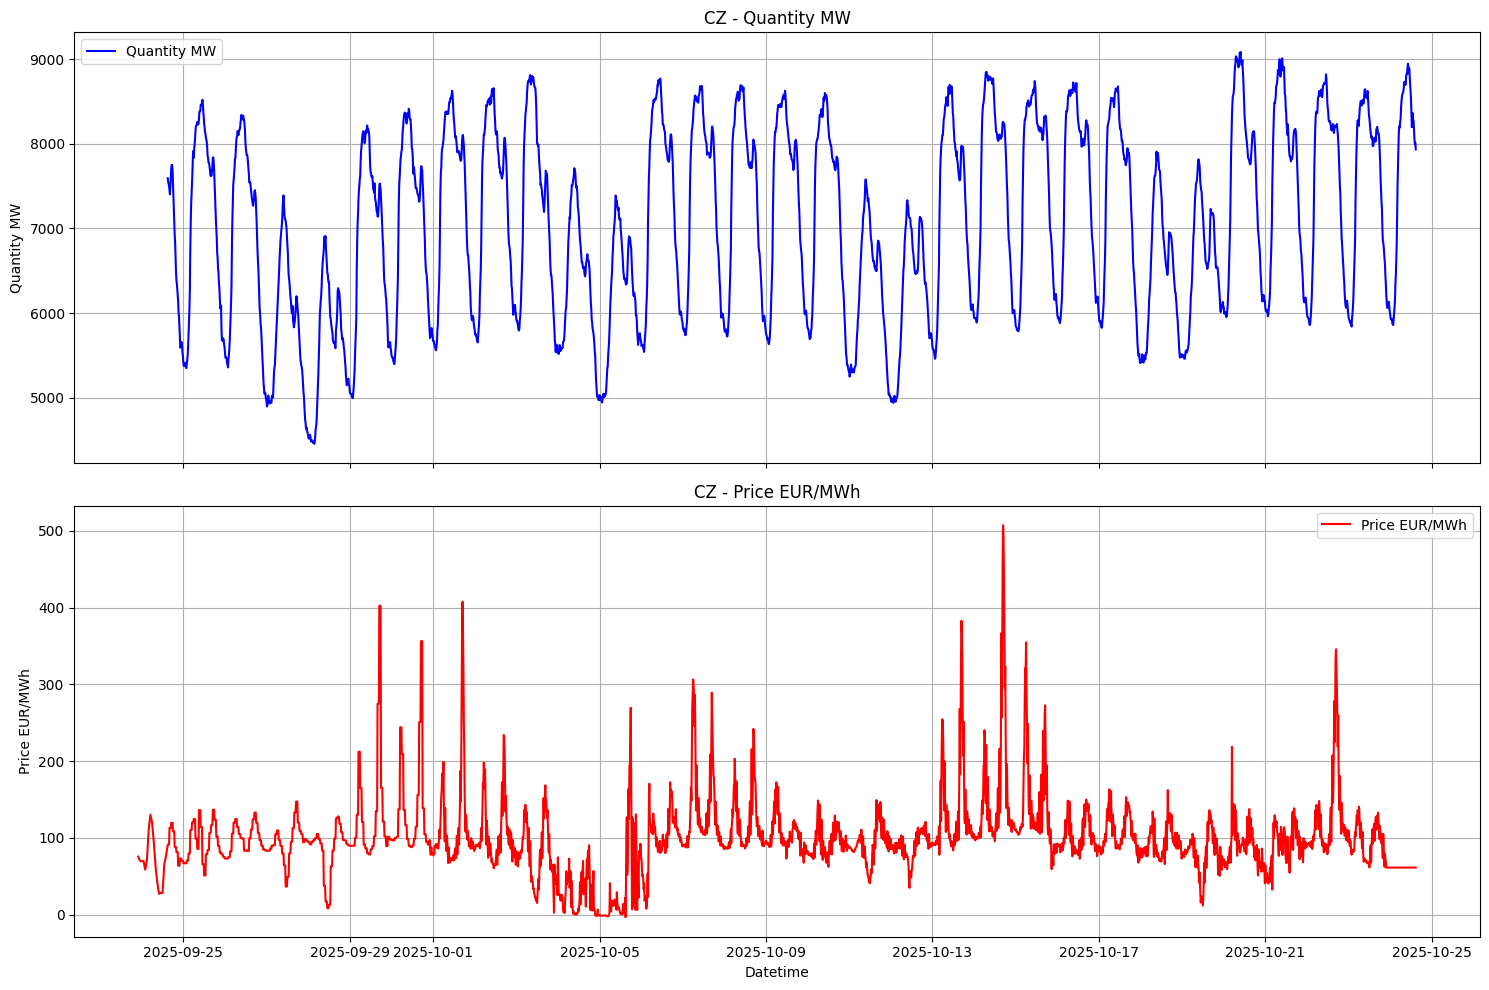

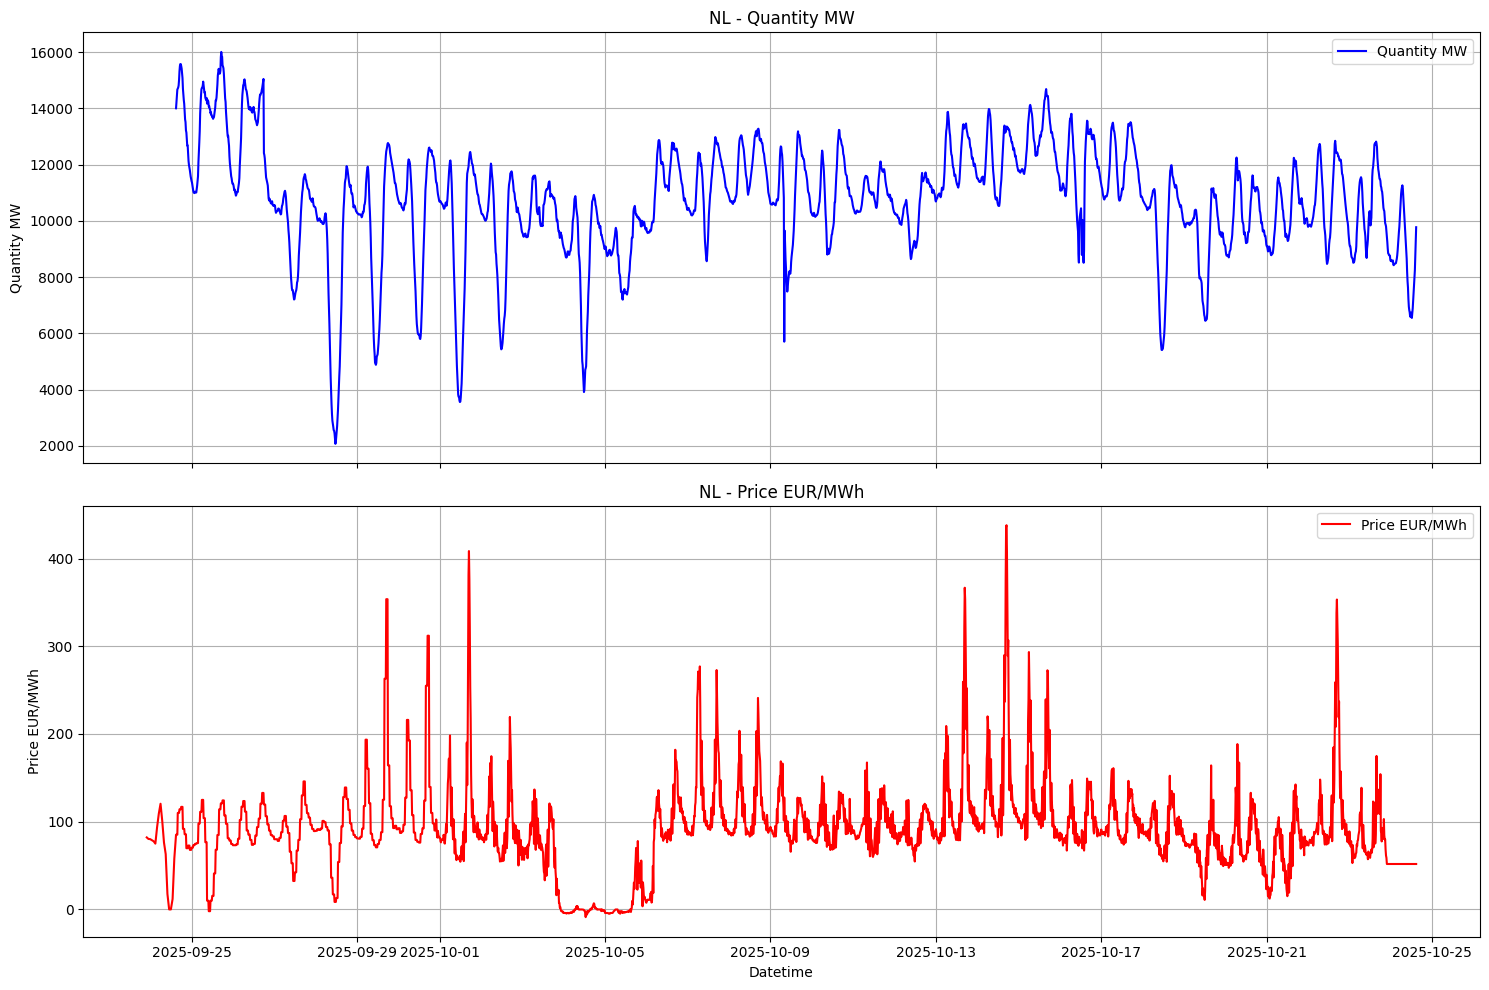

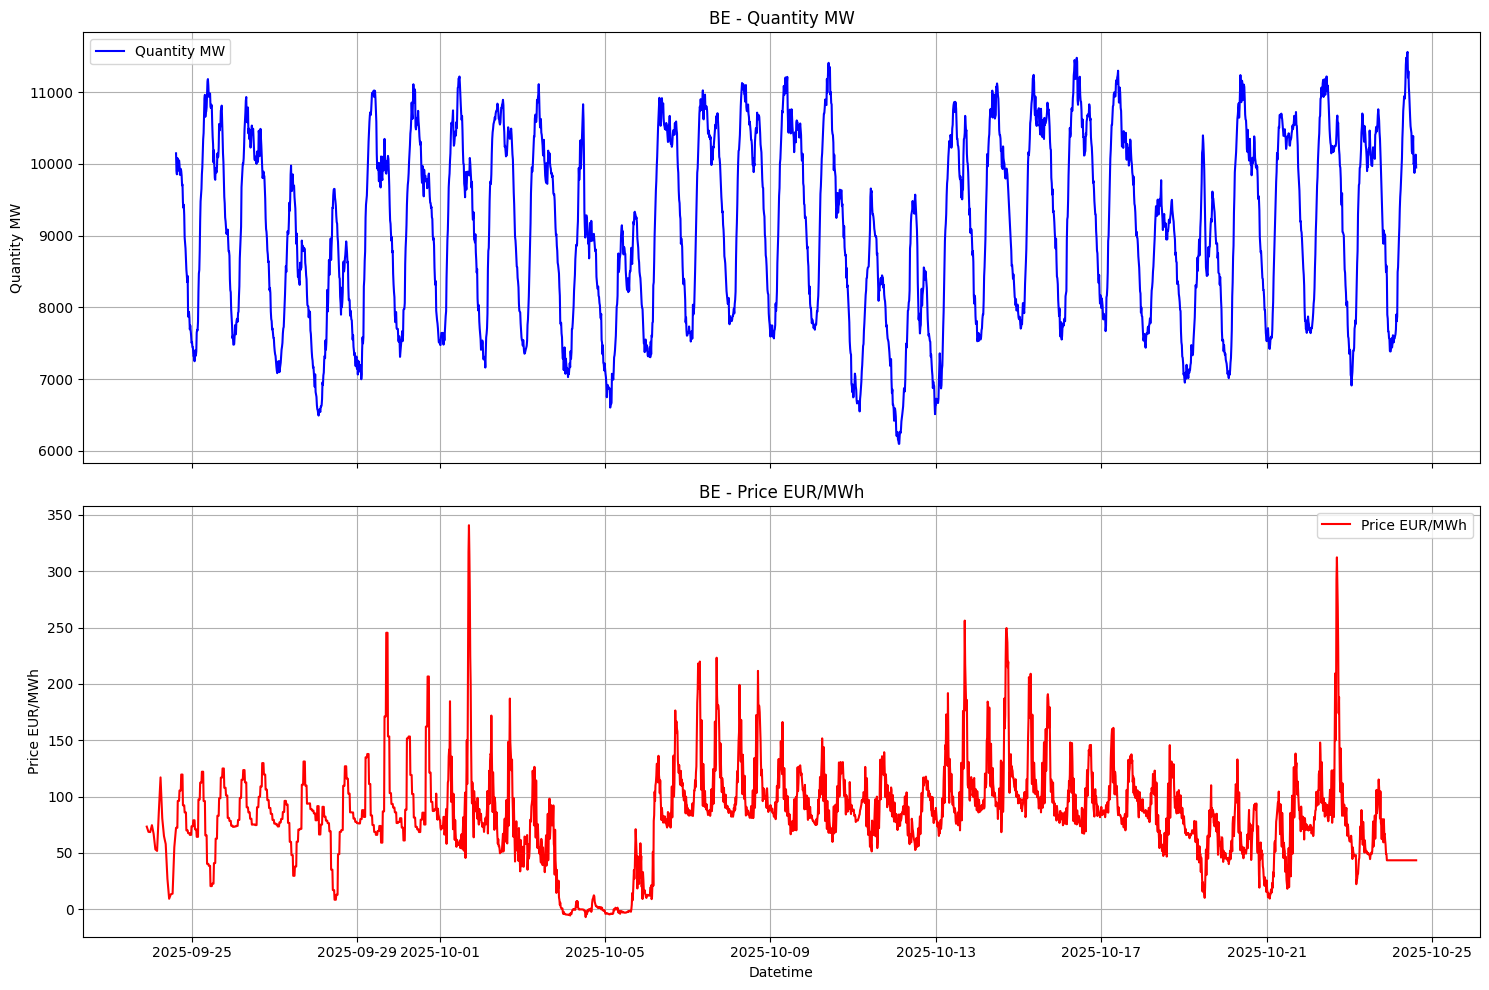

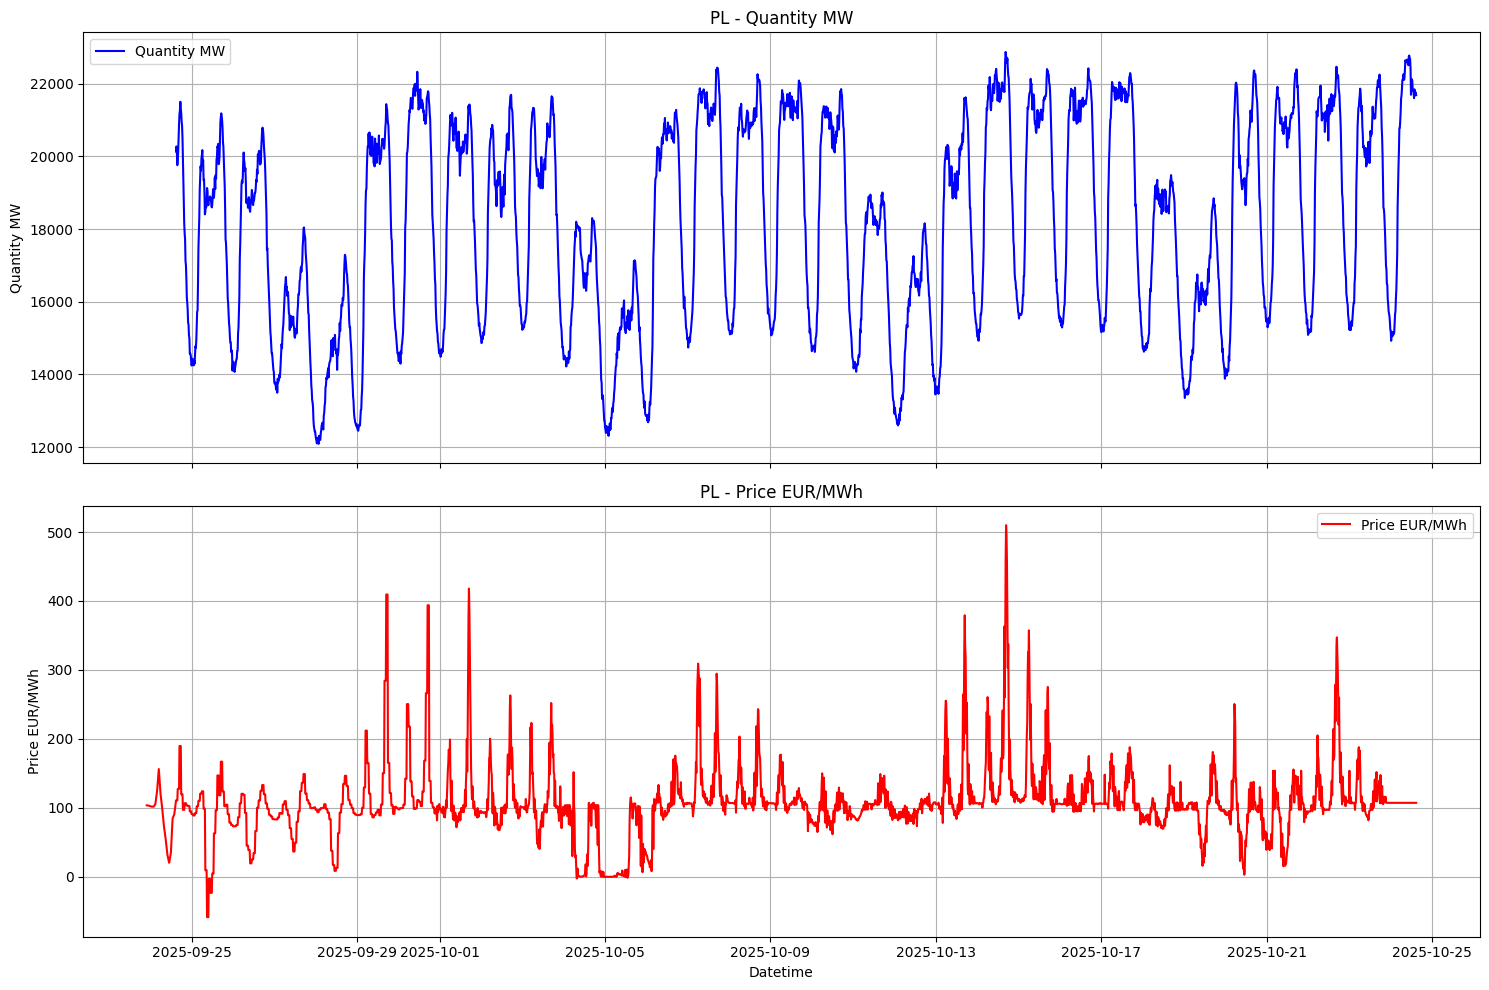

In [7]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# ---------------- CONFIG ---------------- #
RAW_DIR = "data/raw"
PARQUET_FILE = os.path.join(RAW_DIR, "raw_dataset.parquet")

for country in COUNTRY_DOMAINS.keys():
    # ---------------- LOAD DATA ---------------- #
    if not os.path.exists(PARQUET_FILE):
        raise FileNotFoundError(f"Parquet file not found at {PARQUET_FILE}. Run fetch_last_days() first.")

    df = pd.read_parquet(PARQUET_FILE)

    # Filter by country and sort by datetime
    df = df[df['country'] == country].sort_values('datetime')

    # ---------------- PLOTTING ---------------- #
    fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

    # Plot Quantity MW
    axes[0].plot(df['datetime'], df['quantity_MW'], color='blue', label='Quantity MW')
    axes[0].set_ylabel('Quantity MW')
    axes[0].set_title(f'{country} - Quantity MW')
    axes[0].legend()
    axes[0].grid(True)

    # Plot Price EUR/MWh
    axes[1].plot(df['datetime'], df['price_EUR_MWh'], color='red', label='Price EUR/MWh')
    axes[1].set_ylabel('Price EUR/MWh')
    axes[1].set_title(f'{country} - Price EUR/MWh')
    axes[1].legend()
    axes[1].grid(True)

    # Common X-axis
    plt.xlabel('Datetime')
    plt.tight_layout()
    plt.show()


## Capitulo 2 — Definição dos Problemas (Carga e Mercado)

Nesta etapa definimos três problemas, agora baseados em carga (load) e mercado (preço de energia). Cada problema possui variantes A/B/C para complexidade crescente.

- Nível 1 — Preço univariado (A44)
  - A: 1 país (ex.: AT), lookback curto (7 dias), horizonte 1 dia (96 passos de 15 min)
  - B: 1 país, lookback longo (180 dias), horizonte 1 dia
  - C: Multi-país (ex.: AT/DE/FR) com lookbacks máximo (365 dias)

- Nível 2 — Preço com exógena de carga (A44 + A65)
  - A/B/C como acima, adicionando a série de carga como exógena

- Nível 3 — Multitarefa (A44 + A65)
  - A/B/C como acima, mas prevendo simultaneamente preço e carga

Abaixo, criamos construtores de datasets (builders) que leem os Parquets salvos em `data/` e montam janelas de treino com passo de 15 minutos, iniciando sempre à meia‑noite do dia. Os builders retornam tuplas (X, Y, feat_cols, target_cols, country).

## Capitulo 3: Definição de melhores formatos para cada modelo

### Formatos recomendados por modelo (15 min, início à meia-noite, H=96)

Premissas gerais:
- Cada linha dos dados brutos representa 15 minutos, começando às 00:00 do dia.
- Horizonte de previsão padrão: H=96 passos (1 dia de 15 min).
- Lookback L (janela de histórico) depende da variante A/B/C dos problemas, mas pode ser limitado por modelo.

| Modelo | Entrada X (tensor) | Alvo Y (tensor) | Horizon (H) | Lead (gap) | Frequência | Armazenamento recomendado | Observações |
|---|---|---|---:|---:|---|---|---|
| Linear (Ridge/Lasso ou Regressor Linear Multi‑Saída) | X: [N, L·F] float32 (janela L de F features, achatada) — alternativa: [N, L, F] e achatar no loader | Y: [N, H] float32 (multissaída direta) | 96 | 0 | 15 min | .npz com arrays: X, Y, feat_names; opcional Parquet “windowed” | Simples e rápido. Útil usar lags (1, 96, 672) e médias móveis na engenharia de features. Para multialvo (preço+carga), Y: [N, H·T]. |
| LSTM (seq2seq) | X_enc: [N, L, F_past] float32; X_future(opcional): [N, H, F_known] (features conhecidas no futuro, ex.: calendário); static(opc.): [N, S] | Y: [N, H, T] float32 (T=1 preço; T=2 preço+carga) | 96 | 0 | 15 min | .npz: {X_enc, X_future, Y, static, feat_lists.json}; salvar metadados (L, H, T, nomes) | Encoder‑decoder com teacher forcing opcional. Recomenda‑se normalização por série e clipping de outliers. L usual: 7–28 dias (limitar mesmo se o raw tiver 365d). |
| Microsoft TFT (Temporal Fusion Transformer) | Formato “long” (tabela) em Parquet: colunas [id, time, target(s), known_future_*, observed_past_*, static_*]. O dataloader recorta janelas [L,H]. | Derivado do target nas janelas do dataloader (não precisa salvar Y em disco pré‑janelado) | 96 | 0 | 15 min | Parquet “long” + JSON/YAML de metadados de papéis dos atributos | Separar papéis: static (ex.: país), observed_past (lags, rolling), known_future (calendário, feriados). Definir encoder_length=L e prediction_length=H no treino. |
| TimesFM | Contexto (histórico): [N, L, T] float32; opcional: known_future [N, H, F_known] se suportado pela lib usada; focar inicialmente em T=1 (preço) | Y: [N, H, T] para fine‑tuning; para inferência pura, só contexto | 96 | 0 | 15 min | .npz: {context, target, feat_lists.json} ou Parquet “long” minimalista (id, time, target) | TimesFM favorece entrada limpa e normalizada por série. Comece univariado (preço). Use L razoável (7–28 dias) para custo/latência; H=96. |

Notas práticas:
- Normalização: padronize por série (z‑score por país) ou robust scaling; persistir estatísticas (mean/std por país) em JSON.
- Alinhamento temporal: garantir que as janelas [L] iniciem em timestamps válidos e que H comece imediatamente após o fim do lookback (lead=0). Se desejar “pular” um período, ajustar lead>0 e deslocar Y.
- Engenharia de features: usar lags (1, 96, 672) e rolling (96, 672) para Linear e como observed_past para LSTM/TFT.
- Multitarefa (preço+carga): definir T=2; para Linear, Y pode ser [N, H·2] (concatenado) ou duas cabeças separadas; para LSTM/TFT, Y: [N, H, 2].
- Tamanhos: N é o número de janelas; L é lookback em passos de 15 min; F/F_past/F_known são contagens de features; S número de atributos estáticos. Guardar feat_lists.json descrevendo cada papel ajuda a reusar os conjuntos. 

### Notas de Otimização e Uso

Esta versão do fluxo de coleta recebeu melhorias focadas em desempenho e reprodutibilidade e foi ajustada para:

1. Sessão HTTP reutilizada com pool e retries para reduzir overhead de conexão e lidar com erros transitórios (429 / 5xx).
2. Chunking automático de janelas longas (`CHUNK_DAYS`) evitando limites práticos da API e permitindo montar períodos maiores via concatenação.
3. Parsing XML mais rápido via `lxml.iterparse` com fallback para `pandas.read_xml`.
4. Dtypes otimizados (`float32`, `Int32`, `category`) diminuindo memória e tamanho de arquivos Parquet.
5. Salvamento Parquet com compressão configurável (`PARQUET_COMPRESSION` = `zstd` por padrão). Ajuste para `snappy` se priorizar velocidade de leitura.
6. Overwrite forçado (`ALWAYS_OVERWRITE=True`) — sempre reescreve os Parquet.
7. Leitura "lazy" nas visualizações (seleção de colunas) para diminuir tempo e uso de RAM.
8. Construção de parâmetros usando apenas valores não nulos; evita requisições inválidas.
9. Frequência padronizada em 15 minutos, iniciando à meia‑noite do dia (96 pontos/dia) para carga e preço.

Variáveis importantes
- `MAX_WORKERS`: ajuste se receber muitos 429; valores entre 4 e 8 costumam ser seguros.
- `CHUNK_DAYS`: use 30 para segurança. Reduza se notar timeouts; aumente apenas se a API aceitar.
- `PARQUET_COMPRESSION`: `zstd` (boa razão de compressão) ou `snappy` (mais rápido, maior tamanho).
- `DATE_RANGES`: fixado em 365 dias (até ontem) conforme solicitado.

Reexecuções
1. Execute as células na ordem: dependências → imports → funções utilitárias → configuração → coleta → visualização → builders (Etapa 2).
2. Verifique se o token está definido.

Token ENTSO‑E
Crie um arquivo `.env` com:
```
ENTSOE_SECURITY_TOKEN=SEU_TOKEN_AQUI
```

Próximos passos sugeridos
- Adicionar sanity checks: validar 96 pontos por dia por arquivo.
- Acrescentar stubs de treino/avaliação para Linear/LSTM/TFT/TimesFM usando os builders L1/L2/L3.
- Implementar cache opcional do XML bruto para debug.

# Etapa 2: Préprocessamento de dados

Etapa de contrução da pipelines de pre-processamento de dados

Cada modelo terá uma classe específica criada especificamente para poder préprocessar seus dados para cada um dos problemas a serem resulvidos em suas respectivas etapas

As classe vai incluir métodos de:

- Encodding
- Decodding
- Normalization
- Denormalization

Ao final do processamento de dados os arquivos será salvos na pasta:

_./data/processed/{model_name}/_


Essa etapa será dividida em 4 capitulos:

1. Linear
2. LSTM
3. TFT
4. Times FM

## Capitulo 0: Classe geral de preprocessamento

In [31]:
import os
from typing import Optional, List, Any
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
import numpy as np
import time

class Preprocessor:
    """Pré-processador base.

    - lag/lead como inteiros são expandidos para ranges [1..N] quando apropriado.
    - feature_cols/target_cols definem bases permitidas e servem como seleção no export.
    - Nenhuma coluna é removida dos dados; seleção ocorre apenas na exportação.
    """
    def __init__(
        self,
        lag: int,
        lead: int,
        country_list: Optional[List[str]] = None,
        *,
        model_name: str = "linear",
        data_dir: str = "data/processed",
        feature_cols: Optional[List[str]] = None,
        target_cols: Optional[List[str]] = None,
    ):
        self.lag = lag
        self.lead = lead
        self.country_list = country_list
        self.model_name = model_name
        self.data_dir = data_dir
        self.save_dir = os.path.join(self.data_dir, self.model_name)
        os.makedirs(self.save_dir, exist_ok=True)

        self.feature_cols: List[str] = list(feature_cols) if feature_cols else []
        self.target_cols: List[str] = list(target_cols) if target_cols else []

        self.norm_objects = {}
        self.encod_objects = {}
        self.df_base = pd.DataFrame()

    def _expand_steps(self, steps, default_max: Optional[int]) -> List[int]:
        """Normaliza passos: int→[1..N], None→[1..default_max], lista→como está."""
        if isinstance(steps, int):
            return list(range(1, steps + 1)) if steps > 0 else [1]
        if steps is None and isinstance(default_max, int) and default_max > 0:
            return list(range(1, default_max + 1))
        if isinstance(steps, (list, tuple)):
            return list(steps)
        return [1]

    def load_data(self, raw_dir: Optional[str] = None) -> pd.DataFrame:
        """Carrega Parquet unificado em data/raw (ou raw_dir) e atualiza self.df_base."""
        base_raw = raw_dir or os.path.join('data', 'raw')
        unified_path = os.path.join(base_raw, f'raw_dataset.parquet')
        if not os.path.exists(unified_path):
            raise FileNotFoundError(f"Arquivo unificado não encontrado: {unified_path}. Execute a coleta primeiro.")
        df = pd.read_parquet(unified_path, engine='pyarrow')
        if 'datetime' in df.columns:
            df['datetime'] = pd.to_datetime(df['datetime'], utc=True)
        if self.country_list and 'country' in df.columns:
            df = df[df['country'].isin(self.country_list)].copy()
        sort_cols = [c for c in ['country', 'datetime'] if c in df.columns]
        if sort_cols:
            df = df.sort_values(sort_cols).reset_index(drop=True)
        self.df_base = df
        return self.df_base

    def encode(self, encode_cols: str = 'datetime', encode_method: str = 'label') -> pd.DataFrame:
        """Codifica de forma não destrutiva e atualiza self.df_base.

        - label: usa LabelEncoder com suporte a NaN via placeholder interno que é revertido no decode.
        - time_cycle: adiciona features de calendário e cíclicas sem remover datetime.
        """
        if self.df_base is None or self.df_base.empty:
            print("df_base vazio. Chame load_data() primeiro.")
            return self.df_base
        df = self.df_base.copy()
        if encode_method == 'label':
            le = LabelEncoder()
            s = df[encode_cols].astype(object)
            le.fit(s)
            df[encode_cols] = le.transform(s)
            # salva metadados incluindo o code do NaN
            self.encod_objects['label'] = {
                'encode_cols': encode_cols,
                'label_encoder': le,
            }
        elif encode_method == 'time_cycle':
            if encode_cols not in df.columns:
                print(f"Coluna {encode_cols} não encontrada para time_cycle.")
                self.df_base = df
                return df
            dt = pd.to_datetime(df[encode_cols], utc=True)
            # Mantém a coluna original e adiciona componentes discretos e cíclicos
            df['year'] = dt.dt.year
            df['month'] = dt.dt.month
            df['day'] = dt.dt.day
            df['hour'] = dt.dt.hour
            df['minute'] = dt.dt.minute
            current_year = time.localtime().tm_year
            df['year_sin'] = np.sin(2 * np.pi * df['year'] / max(current_year, 1))
            df['year_cos'] = np.cos(2 * np.pi * df['year'] / max(current_year, 1))
            df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
            df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
            df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
            df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)
            df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
            df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
            df['minute_sin'] = np.sin(2 * np.pi * df['minute'] / 60)
            df['minute_cos'] = np.cos(2 * np.pi * df['minute'] / 60)
            self.encod_objects['time_cycle'] = {'encode_cols': encode_cols}
        else:
            print(f"encode_method '{encode_method}' não suportado.")
        self.df_base = df
        self.feature_cols.extend(df.columns[df.columns.str.contains('_sin|_cos')].tolist())
        return self.df_base

    def decode(self, encode_method: str = 'label', target_col: Optional[str] = None) -> pd.DataFrame:
        """Reverte codificações suportadas (label, time_cycle)."""
        if self.df_base is None or self.df_base.empty:
            print("df_base vazio. Nada para decodificar.")
            return self.df_base
        df = self.df_base.copy()
        if encode_method == 'label':
            info = self.encod_objects.get('label')
            if not info:
                print("Nenhuma informação de label encoding salva.")
                return self.df_base
            col = info['encode_cols']
            le: LabelEncoder = info['label_encoder']
            placeholder = info.get('na_placeholder', '__NA__')
            try:
                inv = le.inverse_transform(df[col].astype(int))
                # mapeia placeholder de volta para NaN
                inv = pd.Series(inv).replace(placeholder, np.nan).values
                df[col] = inv
            except Exception as e:
                print(f"Falha ao decodificar label para coluna {col}: {e}")
        elif encode_method == 'time_cycle':
            if 'year' not in df.columns:
                print("Componentes de tempo ausentes para reconstrução.")
                return self.df_base
            tgt = target_col or 'decoded_datetime'
            def _recover_component(sin_col, cos_col, period, offset):
                if sin_col not in df.columns or cos_col not in df.columns:
                    return pd.Series([np.nan] * len(df))
                ang = np.arctan2(df[sin_col], df[cos_col])
                ang = (ang + 2 * np.pi) % (2 * np.pi)
                idx = np.round((ang / (2 * np.pi)) * period).astype('Int64') % period
                return idx + offset
            month = _recover_component('month_sin', 'month_cos', 12, 1)
            day = _recover_component('day_sin', 'day_cos', 31, 1)
            hour = _recover_component('hour_sin', 'hour_cos', 24, 0)
            minute = _recover_component('minute_sin', 'minute_cos', 60, 0)
            year = df['year'] if 'year' in df.columns else pd.Series([np.nan] * len(df))
            dt = pd.to_datetime({
                'year': year.astype('Int64'),
                'month': month.astype('Int64'),
                'day': day.astype('Int64'),
                'hour': hour.astype('Int64'),
                'minute': minute.astype('Int64'),
            }, errors='coerce', utc=True)
            df[tgt] = dt
        else:
            print(f"encode_method '{encode_method}' não suportado para decode.")
        self.df_base = df
        return self.df_base

    def normalize(
        self,
        value_cols: List[str],
        normalization_method: str = 'minmax',
        fit: bool = True,
        scaler: Optional[Any] = None
    ) -> pd.DataFrame:
        """Normaliza colunas e atualiza self.df_base.

        Se fit=True, ajusta o scaler nos dados e salva o modelo.
        Se fit=False, usa o scaler fornecido para transformar os dados.
        """
        if self.df_base is None or self.df_base.empty:
            print("df_base vazio. Chame load_data() primeiro.")
            return self.df_base

        df = self.df_base.copy()
        if normalization_method == 'minmax':
            scaler_cls = MinMaxScaler
        elif normalization_method == 'standard':
            scaler_cls = StandardScaler
        else:
            raise ValueError("normalization_method deve ser 'minmax' ou 'standard'")

        if fit:
            scaler = scaler_cls()
            df[value_cols] = scaler.fit_transform(df[value_cols])
            self.norm_objects[normalization_method] = {'value_cols': value_cols, 'scaler': scaler}
        else:
            if scaler is None:
                info = self.norm_objects.get(normalization_method)
                if not info:
                    raise ValueError(f"Nenhum scaler salvo para o método '{normalization_method}'.")
                scaler = info['scaler']
            df[value_cols] = scaler.transform(df[value_cols])

        self.df_base = df
        return self.df_base


    def denormalize(self, normalization_method: str = 'minmax') -> pd.DataFrame:
        """Reverte normalização usando metadados salvos."""
        if self.df_base is None or self.df_base.empty:
            print("df_base vazio. Nada para denormalizar.")
            return self.df_base
        info = self.norm_objects.get(normalization_method)
        if not info:
            print(f"Nenhum scaler salvo para o método '{normalization_method}'.")
            return self.df_base
        cols: List[str] = info['value_cols']
        scaler = info['scaler']
        df = self.df_base.copy()
        try:
            df[cols] = scaler.inverse_transform(df[cols])
        except Exception as e:
            print(f"Falha ao denormalizar colunas {cols}: {e}")
            return self.df_base
        self.df_base = df
        return self.df_base

    def save_df_base(self, filename: Optional[str] = None, compression: Optional[str] = None, partition_by: Optional[List[str]] = None) -> Optional[str]:
        """Salva self.df_base em Parquet dentro de data_dir/{model_name}."""
        if self.df_base is None or self.df_base.empty:
            print("df_base vazio. Nada para salvar.")
            return None
        comp = compression
        if comp is None:
            try:
                comp = PARQUET_COMPRESSION
            except NameError:
                comp = 'zstd'
        filename = "raw_dataset.parquet"
        out_path = os.path.join(self.save_dir, filename)
        df = self.df_base.copy()
        if 'datetime' in df.columns:
            df['datetime'] = pd.to_datetime(df['datetime'], utc=True)
        try:
            if partition_by:
                df.to_parquet(out_path, engine='pyarrow', compression=comp, index=False, partition_cols=partition_by)
            else:
                df.to_parquet(out_path, engine='pyarrow', compression=comp, index=False)
            print(f"[SALVO] df_base: {len(df):,} linhas → {out_path}")
            return out_path
        except Exception as e:
            print(f"Falha ao salvar df_base em {out_path}: {e}")
            return None
    def train_val_test_split(self, train_prop=0.7, val_prop=0.15, test_prop=0.15, order_col='datetime'):
        """Divide self.df_base em train/val/test conjuntos baseados em proporções temporais."""
        if self.df_base is None or self.df_base.empty:
            print("df_base vazio. Nada para dividir.")
            return None, None, None
        df = self.df_base.copy()
        if order_col not in df.columns:
            print(f"Coluna de ordenação '{order_col}' não encontrada em df_base.")
            return None, None, None
        df = df.sort_values(order_col).reset_index(drop=True)
        n = len(df)
        train_end = int(n * train_prop)
        val_end = train_end + int(n * val_prop)
        train_df = df.iloc[:train_end].reset_index(drop=True)
        val_df = df.iloc[train_end:val_end].reset_index(drop=True)
        test_df = df.iloc[val_end:].reset_index(drop=True)
        print(f"[DIVIDIDO] Train: {len(train_df):,}, Val: {len(val_df):,}, Test: {len(test_df):,}")
        self.splits = {
            'train': train_df,
            'val': val_df,
            'test': test_df
        }
        return self.splits
    
    def normalize_splits(self, value_cols, normalization_method='minmax'):
        """Normaliza os conjuntos train/val/test usando o conjunto de treino para ajuste."""
        if not hasattr(self, 'splits'):
            print("Nenhum split encontrado. Chame train_val_test_split() primeiro.")
            return None
        train_df = self.splits['train']
        val_df = self.splits['val']
        test_df = self.splits['test']
        
        self.df_base = train_df
        train_df = self.normalize(value_cols, normalization_method, fit=True)

        self.df_base = val_df
        val_df = self.normalize(value_cols, normalization_method, fit=False, scaler=self.norm_objects[normalization_method]['scaler'])

        self.df_base = test_df
        test_df = self.normalize(value_cols, normalization_method, fit=False, scaler=self.norm_objects[normalization_method]['scaler'])

        self.splits = {
            'train': train_df,
            'val': val_df,
            'test': test_df
        }
        return self.splits

## Capítulo 1: Preprocessamento do Modelo Linear

Esse modelo deve será contruido a partir de lags e leads passados como parâmetros na função, resultando na contrução de novas colunas lead lag, assim gerando uma flat matrix 2D que será usada no modelo linear

Observação importante: lag e lead são inteiros e representam o máximo de passos; o pipeline expande para intervalos 1..N automaticamente. Por exemplo, lag=96 gera features com defasagens de 1 a 96; lead=96 gera alvos de 1 a 96.

Os arquivos do modelo serão salvos em TFrecords já que o modelo linear será contruído usando tensor flow

In [32]:
class LinearPreprocessor(Preprocessor):
    """Pré-processador linear: gera matriz flat (lags/leads) e exporta TFRecords.

    Princípios:
    - Não remove colunas do df_base, apenas adiciona as derivadas.
    - Usa feature_cols/target_cols definidos no construtor do Preprocessor.
    - Seleção é estrita apenas na exportação (TFRecords).
    """

    def build_flat_matrix(
        self,
        value_cols: Optional[List[str]] = None,
        target: Optional[str] = None,
        lags: Optional[int] = None,
        leads: Optional[int] = None,
        dropna: bool = True,
        group_cols: Optional[List[str]] = None,
        time_col: str = "datetime",
    ) -> pd.DataFrame:
        if self.df_base is None or self.df_base.empty:
            print("df_base vazio. Chame load_data() primeiro.")
            return self.df_base

        df = self.df_base.copy()
        feats = value_cols or self.feature_cols
        tgt = target or (self.target_cols[0] if self.target_cols else None)
        if not feats:
            raise ValueError("Nenhuma coluna de feature informada.")
        if tgt is None:
            raise ValueError("Nenhum target informado.")

        group_cols = group_cols or [c for c in ["country"] if c in df.columns]

        # Ensure time_col exists
        if time_col not in df.columns:
            raise ValueError(f"Coluna temporal '{time_col}' não encontrada no DataFrame.")

        # Sorting by group and time (MUST BE DONE)
        sort_cols = (group_cols or []) + [time_col]
        df = df.sort_values(sort_cols).reset_index(drop=True)

        # Make sure time order is preserved
        if group_cols:
            df["_group_id"] = df[group_cols].astype(str).agg("_".join, axis=1)
        else:
            df["_group_id"] = "global"

        lag_steps = list(range(1, (lags or self.lag or 0) + 1))
        lead_steps = list(range(1, (leads or self.lead or 0) + 1))

        new_cols = []

        # ---- Lags ----
        for col in feats:
            if col not in df.columns:
                print(f"[WARN] Coluna de feature '{col}' não encontrada.")
                continue
            for k in lag_steps:
                cname = f"{col}_lag{k}"
                df[cname] = (
                    df.groupby("_group_id", group_keys=False, sort=False)[col].shift(k)
                )
                new_cols.append(cname)

        # ---- Leads ----
        if tgt in df.columns:
            for k in lead_steps:
                cname = f"{tgt}_lead{k}"
                df[cname] = (
                    df.groupby("_group_id", group_keys=False, sort=False)[tgt].shift(-k)
                )
                new_cols.append(cname)
        else:
            print(f"[WARN] Target '{tgt}' não encontrado. Ignorando leads.")

        # Drop rows that don't have all required lags/leads
        if dropna and new_cols:
            df = df.dropna(subset=new_cols).reset_index(drop=True)

        # Clean temp columns
        df.drop(columns=["_group_id"], inplace=True, errors="ignore")

        self.df_base = df
        return self.df_base


    def save_tfrecords(
        self,
        output_basename: str = 'dataset',
        shard_size: int = 100_000,
        compression: Optional[str] = None,
    ) -> Optional[List[str]]:
        if self.df_base is None or self.df_base.empty:
            print("df_base vazio. Nada para salvar em TFRecords.")
            return None
        try:
            import tensorflow as tf
        except Exception as e:
            print(f"TensorFlow não disponível: {e}")
            return None

        # Seleção estrita: apenas colunas configuradas e existentes
        numeric_cols = self.df_base.select_dtypes(include=["number", "bool"]).columns
        present_feats = [c for c in self.feature_cols if c in numeric_cols]
        present_tgts = [c for c in self.target_cols if c in numeric_cols]
        if not present_feats:
            print("Nenhuma feature presente no df_base para export.")
            return None
        if not present_tgts:
            print("Nenhum target presente no df_base para export.")
            return None

        missing_feats = [c for c in self.feature_cols if c not in present_feats]
        missing_tgts = [c for c in self.target_cols if c not in present_tgts]
        if missing_feats:
            print(f"[WARN] Features ausentes: {missing_feats}")
        if missing_tgts:
            print(f"[WARN] Targets ausentes: {missing_tgts}")

        df = self.df_base.reset_index(drop=True)
        X = df[present_feats].astype('float32').to_numpy(copy=False)
        y = df[present_tgts].astype('float32').to_numpy(copy=False)

        x_dim = X.shape[1]
        y_dim = y.shape[1]
        n = len(df)

        def _float_feature(v):
            return tf.train.Feature(float_list=tf.train.FloatList(value=v))

        def _serialize_row(i):
            example = tf.train.Example(features=tf.train.Features(feature={
                'x': _float_feature(X[i]),
                'y': _float_feature(y[i]),
            }))
            return example.SerializeToString()

        comp = compression or 'GZIP'
        options = tf.io.TFRecordOptions(compression_type=comp) if comp else None

        paths: List[str] = []
        for shard_idx, start in enumerate(range(0, n, shard_size)):
            end = min(start + shard_size, n)
            shard_path = os.path.join(self.save_dir, f"{output_basename}.tfrecord")
            with tf.io.TFRecordWriter(shard_path, options=options) as w:
                for i in range(start, end):
                    w.write(_serialize_row(i))
            paths.append(shard_path)

        # Metadados
        meta = {
            'x_dim': int(x_dim),
            'y_dim': int(y_dim),
            'feature_cols': present_feats,
            'target_cols': present_tgts,
            'count': int(n),
            'compression': comp or 'NONE',
            'basename': output_basename,
        }
        try:
            import json
            with open(os.path.join(self.save_dir, f"{output_basename}.meta.json"), 'w', encoding='utf-8') as f:
                json.dump(meta, f, ensure_ascii=False, indent=2)
        except Exception as e:
            print(f"[WARN] Falha ao salvar metadados: {e}")

        print(f"[SALVO] TFRecords: {len(paths)} shard(s) em {self.save_dir}")
        return paths
    def build_flat_matrix_split(
        self,
        value_cols: Optional[List[str]] = None,
        target: Optional[str] = None,
        lags: Optional[int] = None,
        leads: Optional[int] = None,
        dropna: bool = True,
        group_cols: Optional[List[str]] = None,
        time_col: str = "datetime",
    ) -> Optional[dict]:
        """Constrói matrizes flat para train/val/test splits."""
        if not hasattr(self, 'splits'):
            print("Nenhum split encontrado. Chame train_val_test_split() primeiro.")
            return None
        results = {}
        for split_name in ['train', 'val', 'test']:
            self.df_base = self.splits[split_name]
            df_flat = self.build_flat_matrix(
                value_cols=value_cols,
                target=target,
                lags=lags,
                leads=leads,
                dropna=dropna,
                group_cols=group_cols,
                time_col=time_col,
            )
            results[split_name] = df_flat
        self.splits = results
        return self.splits
    def save_tfrecords_split(
        self,
        output_basename: str = 'dataset',
        shard_size: int = 100_000,
        compression: Optional[str] = None,
    ) -> Optional[List[str]]:
        if not hasattr(self, 'splits'):
            print("Nenhum split encontrado. Chame train_val_test_split() primeiro.")
            return None
        for split_name in ['train', 'val', 'test']:
            self.df_base = self.splits[split_name]
            self.save_tfrecords(
                output_basename = f"{output_basename}_{split_name}",
                shard_size = shard_size,
                compression = compression
            )
            

## Capítulo 2 — LSTM: Pré-processamento

Este capítulo prepara janelas sequenciais para modelos LSTM a partir do `df_base` do Preprocessor.

- Entrada: janelas com `lookback` passos de `feature_cols`
- Saída: janelas com `horizon` passos de `target_cols`
- Agrupamento por país (ou outra chave) garante que sequências não cruzem fronteiras de séries.

In [33]:
from typing import Tuple

class LSTMPreprocessor(Preprocessor):
    """Gera janelas sequenciais para LSTM a partir de df_base.

    - X: [num_windows, lookback, n_features]
    - y: [num_windows, horizon, n_targets]
    - Respeita separação por grupos (p.ex., país) e ordena por datetime quando disponível.
    """

    def build_sequences(
        self,
        lookback: int,
        horizon: int,
        group_cols: Optional[List[str]] = None,
        time_col: str = 'datetime',
        feature_cols: Optional[List[str]] = None,
        target_cols: Optional[List[str]] = None,
    ) -> Tuple[np.ndarray, np.ndarray]:
        if self.df_base is None or self.df_base.empty:
            raise ValueError("df_base vazio. Carregue dados com load_data().")
        feats = feature_cols or self.feature_cols
        tgts = target_cols or self.target_cols
        if not feats or not tgts:
            raise ValueError("feature_cols e target_cols devem estar definidos.")
        df = self.df_base.copy()
        # Ordenação por grupo e tempo
        group_cols = group_cols or [c for c in ['country'] if c in df.columns]
        if group_cols:
            sort_by = group_cols + ([time_col] if time_col in df.columns else [])
            if sort_by:
                df = df.sort_values(sort_by).reset_index(drop=True)
        else:
            if time_col in df.columns:
                df = df.sort_values(time_col).reset_index(drop=True)

        X_list, y_list = [], []
        if group_cols:
            for _, g in df.groupby(group_cols, sort=False):
                Xg, yg = self._windows_from_frame(g, feats, tgts, lookback, horizon)
                if Xg.size and yg.size:
                    X_list.append(Xg)
                    y_list.append(yg)
        else:
            Xg, yg = self._windows_from_frame(df, feats, tgts, lookback, horizon)
            if Xg.size and yg.size:
                X_list.append(Xg)
                y_list.append(yg)
        if not X_list:
            return np.empty((0, lookback, len(feats)), dtype=np.float32), np.empty((0, horizon, len(tgts)), dtype=np.float32)
        X = np.concatenate(X_list, axis=0)
        y = np.concatenate(y_list, axis=0)
        return X.astype(np.float32, copy=False), y.astype(np.float32, copy=False)

    @staticmethod
    def _windows_from_frame(g: pd.DataFrame, feats: List[str], tgts: List[str], lookback: int, horizon: int) -> Tuple[np.ndarray, np.ndarray]:
        f = g[feats].to_numpy(dtype=np.float32, copy=False)
        t = g[tgts].to_numpy(dtype=np.float32, copy=False)
        n = len(g)
        win = lookback + horizon
        if n < win:
            return np.empty((0, lookback, len(feats)), dtype=np.float32), np.empty((0, horizon, len(tgts)), dtype=np.float32)
        X, Y = [], []
        for i in range(n - win + 1):
            X.append(f[i:i+lookback])
            Y.append(t[i+lookback:i+win])
        return np.array(X, dtype=np.float32), np.array(Y, dtype=np.float32)


## Capítulo 3 — TFT: Pré-processamento

Este capítulo prepara tensores para o Temporal Fusion Transformer (TFT).

- Suporta variáveis estáticas por série (ex.: país) e variáveis conhecidas do futuro (ex.: calendário)
- Saídas esperadas: triplo (encoder, decoder, targets) com shapes padronizados
- Mantém alocação eficiente e seleção baseada em feature_cols/target_cols

In [34]:
from typing import Dict

class TFTPreprocessor(Preprocessor):
    """Prepara tensores para o Temporal Fusion Transformer (TFT).

    Produz um dicionário com:
    - encoder: [N, enc_len, n_feat]
    - decoder: [N, dec_len, n_feat_known_future]
    - target:  [N, dec_len, n_tgt]
    """

    def build_tensors(
        self,
        enc_len: int,
        dec_len: int,
        group_cols: Optional[List[str]] = None,
        time_col: str = 'datetime',
        feature_cols: Optional[List[str]] = None,
        known_future_cols: Optional[List[str]] = None,
        target_cols: Optional[List[str]] = None,
    ) -> Dict[str, np.ndarray]:
        if self.df_base is None or self.df_base.empty:
            raise ValueError("df_base vazio. Carregue dados com load_data().")
        feats = feature_cols or self.feature_cols
        tgts = target_cols or self.target_cols
        known = known_future_cols or [c for c in feats if c.endswith(('_sin', '_cos')) or c in ('month', 'day', 'hour', 'minute')]
        if not feats or not tgts:
            raise ValueError("feature_cols e target_cols devem estar definidos.")
        df = self.df_base.copy()
        # Ordenação por grupo e tempo
        group_cols = group_cols or [c for c in ['country'] if c in df.columns]
        if group_cols:
            sort_by = group_cols + ([time_col] if time_col in df.columns else [])
            if sort_by:
                df = df.sort_values(sort_by).reset_index(drop=True)
        else:
            if time_col in df.columns:
                df = df.sort_values(time_col).reset_index(drop=True)

        def _split_windows(g: pd.DataFrame):
            F = g[feats].to_numpy(dtype=np.float32, copy=False)
            K = g[known].to_numpy(dtype=np.float32, copy=False) if known else np.empty((len(g), 0), dtype=np.float32)
            T = g[tgts].to_numpy(dtype=np.float32, copy=False)
            n = len(g)
            win = enc_len + dec_len
            enc_list, dec_list, tgt_list = [], [], []
            for i in range(n - win + 1):
                enc_list.append(F[i:i+enc_len])
                # no decoder, geralmente usamos apenas variáveis conhecidas do futuro
                dec_list.append(K[i+enc_len:i+win] if K.shape[1] > 0 else np.zeros((dec_len, 0), dtype=np.float32))
                tgt_list.append(T[i+enc_len:i+win])
            if not enc_list:
                return np.empty((0, enc_len, len(feats)), dtype=np.float32), \
                       np.empty((0, dec_len, K.shape[1] if K.size else 0), dtype=np.float32), \
                       np.empty((0, dec_len, len(tgts)), dtype=np.float32)
            return (
                np.array(enc_list, dtype=np.float32),
                np.array(dec_list, dtype=np.float32),
                np.array(tgt_list, dtype=np.float32),
            )

        enc_all, dec_all, tgt_all = [], [], []
        if group_cols:
            for _, g in df.groupby(group_cols, sort=False):
                e, d, t = _split_windows(g)
                if e.size:
                    enc_all.append(e); dec_all.append(d); tgt_all.append(t)
        else:
            e, d, t = _split_windows(df)
            if e.size:
                enc_all.append(e); dec_all.append(d); tgt_all.append(t)

        if not enc_all:
            return {'encoder': np.empty((0, enc_len, len(feats)), dtype=np.float32),
                    'decoder': np.empty((0, dec_len, len(known)), dtype=np.float32),
                    'target':  np.empty((0, dec_len, len(tgts)), dtype=np.float32)}

        encoder = np.concatenate(enc_all, axis=0)
        decoder = np.concatenate(dec_all, axis=0)
        target  = np.concatenate(tgt_all, axis=0)
        return {'encoder': encoder, 'decoder': decoder, 'target': target}


## Capítulo 4 — TimesFM: Pré-processamento

Este capítulo prepara a série e metadados no formato típico de modelos foundation de séries temporais (ex.: TimesFM).

- Saída: listas/dicionários prontos para consumo por APIs de inferência
- Seleciona colunas alvo e contextuais e organiza por série (país) mantendo a cadência de 15 minutos

In [35]:
class TimesFMPreprocessor(Preprocessor):
    """Prepara dados no formato simplificado para TimesFM-like modelos foundation.

    Produz um dicionário:
    - series: lista de arrays 1D (targets) por série (ex.: país)
    - context: lista de dataframes/arrays com features contextuais alinhadas
    - index: lista de índices de tempo para referência externa
    """

    def build_payload(
        self,
        group_cols: Optional[List[str]] = None,
        time_col: str = 'datetime',
        feature_cols: Optional[List[str]] = None,
        target_cols: Optional[List[str]] = None,
    ) -> Dict[str, List]:
        if self.df_base is None or self.df_base.empty:
            raise ValueError("df_base vazio. Carregue dados com load_data().")
        feats = feature_cols or self.feature_cols
        tgts = target_cols or self.target_cols
        if not tgts:
            raise ValueError("target_cols deve estar definido para gerar a série principal.")
        df = self.df_base.copy()
        group_cols = group_cols or [c for c in ['country'] if c in df.columns]
        # Ordenação
        sort_by = (group_cols or []) + ([time_col] if time_col in df.columns else [])
        if sort_by:
            df = df.sort_values(sort_by).reset_index(drop=True)
        # Preparação por série
        series_list, context_list, index_list = [], [], []
        if group_cols:
            for _, g in df.groupby(group_cols, sort=False):
                idx = g[time_col].tolist() if time_col in g.columns else list(range(len(g)))
                y = g[tgts].to_numpy(dtype=np.float32, copy=False)
                # Se múltiplos targets, concatena/seleciona o primeiro como série principal
                y1d = y[:, 0] if y.ndim == 2 and y.shape[1] >= 1 else y.ravel()
                series_list.append(y1d)
                ctx = g[feats].to_numpy(dtype=np.float32, copy=False) if feats else np.empty((len(g), 0), dtype=np.float32)
                context_list.append(ctx)
                index_list.append(idx)
        else:
            g = df
            idx = g[time_col].tolist() if time_col in g.columns else list(range(len(g)))
            y = g[tgts].to_numpy(dtype=np.float32, copy=False)
            y1d = y[:, 0] if y.ndim == 2 and y.shape[1] >= 1 else y.ravel()
            series_list.append(y1d)
            ctx = g[feats].to_numpy(dtype=np.float32, copy=False) if feats else np.empty((len(g), 0), dtype=np.float32)
            context_list.append(ctx)
            index_list.append(idx)
        return {'series': series_list, 'context': context_list, 'index': index_list}


# Etapa 3 — Construção dos Modelos

A seguir, definimos construtores simples e eficientes para cada modelo (Linear, LSTM, TFT e TimesFM),
prontos para uso em rotinas de otimização de hiperparâmetros (por exemplo, Optuna). Cada construtor
recebe um dicionário de parâmetros (`params`) e retorna um modelo compilado.

## Capítulo 1 — Linear: Construção do Modelo

Objetivo: um regressor denso simples (MLP) para prever `target_cols` a partir de `feature_cols`.

Contrato rápido:
- Entrada: vetor de tamanho `x_dim` (número de features)
- Saída: vetor de tamanho `y_dim` (número de targets)
- Parâmetros (exemplos): hidden_units, activation, dropout, lr, l2

In [36]:
from typing import Dict, Any
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


def build_linear_model(x_dim: int, y_dim: int, params: Dict[str, Any]) -> keras.Model:
    """Constrói um MLP simples para regressão multivariada.

    params:
      - hidden_units: List[int]
      - activation: str (ex.: 'relu')
      - dropout: float (0..1)
      - l2: float (regularização L2)
      - lr: float (learning rate)
    """
    hidden_units = params.get('hidden_units', [128, 64])
    activation = params.get('activation', 'relu')
    dropout = float(params.get('dropout', 0.0))
    l2 = float(params.get('l2', 0.0))
    lr = float(params.get('lr', 1e-3))

    inputs = keras.Input(shape=(x_dim,), name='features')
    x = inputs
    for i, units in enumerate(hidden_units):
        x = layers.Dense(units, activation=activation,
                         kernel_regularizer=keras.regularizers.l2(l2),
                         name=f'dense_{i}')(x)
        if dropout > 0:
            x = layers.Dropout(dropout, name=f'dropout_{i}')(x)
    outputs = layers.Dense(y_dim, name='targets')(x)

    model = keras.Model(inputs, outputs, name='linear_mlp')
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
                  loss='mse', metrics=['mae'])
    return model

# Uso (exemplo)
# model = build_linear_model(x_dim=len(feature_cols), y_dim=len(target_cols),
#                            params={'hidden_units':[128,64], 'activation':'relu', 'dropout':0.1, 'l2':1e-6, 'lr':1e-3})
# model.summary()

## Capítulo 2 — LSTM: Construção do Modelo

Objetivo: um seq2seq LSTM para prever `horizon` passos à frente (multi-step) usando `lookback` passos de entrada.

Contrato rápido:
- Entrada: [lookback, x_dim]
- Saída: [horizon, y_dim]
- Parâmetros: units, dropout, lr, l2, bidirectional (bool)

In [37]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def build_lstm_model(lookback: int, x_dim: int, horizon: int, y_dim: int, params: Dict[str, Any]) -> keras.Model:
    """Seq2seq LSTM simples com RepeatVector + TimeDistributed.

    params:
      - units: int (tamanho das camadas LSTM)
      - layers: int (nº de camadas LSTM no encoder/decoder)
      - bidirectional: bool
      - dropout: float (0..1)
      - lr: float
      - l2: float
    """
    units = int(params.get('units', 128))
    layers_n = int(params.get('layers', 1))
    bidir = bool(params.get('bidirectional', False))
    dropout = float(params.get('dropout', 0.0))
    lr = float(params.get('lr', 1e-3))
    l2 = float(params.get('l2', 0.0))

    inputs = keras.Input(shape=(lookback, x_dim), name='seq_in')
    x = inputs
    for i in range(layers_n):
        lstm = layers.LSTM(units, return_sequences=(i < layers_n - 1),
                           kernel_regularizer=keras.regularizers.l2(l2), name=f'enc_lstm_{i}')
        x = (layers.Bidirectional(lstm, name=f'enc_bi_{i}')(x) if bidir else lstm(x))
        if dropout > 0:
            x = layers.Dropout(dropout, name=f'enc_drop_{i}')(x)

    x = layers.RepeatVector(horizon, name='repeat')(x)

    for i in range(layers_n):
        x = layers.LSTM(units, return_sequences=True,
                        kernel_regularizer=keras.regularizers.l2(l2), name=f'dec_lstm_{i}')(x)
        if dropout > 0:
            x = layers.Dropout(dropout, name=f'dec_drop_{i}')(x)

    outputs = layers.TimeDistributed(layers.Dense(y_dim), name='td_out')(x)

    model = keras.Model(inputs, outputs, name='lstm_seq2seq')
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
                  loss='mse', metrics=['mae'])
    return model

# Uso (exemplo)
# model = build_lstm_model(lookback=96, x_dim=len(feature_cols), horizon=4, y_dim=len(target_cols),
#                          params={'units':128, 'layers':1, 'bidirectional':False, 'dropout':0.1, 'lr':1e-3, 'l2':1e-6})
# model.summary()

## Capítulo 3 — TFT: Construção do Modelo

Objetivo: um modelo inspirado no Temporal Fusion Transformer (versão simplificada) com encoder/decoder e atenção multihead.

Contrato rápido:
- Entradas: encoder [enc_len, x_dim], decoder_known [dec_len, k_dim]
- Saída: [dec_len, y_dim]
- Parâmetros: num_heads, key_dim, ff_dim, layers, dropout, lr, l2

In [38]:
# Implementação correta (oficial) do TFT via PyTorch Forecasting
from typing import List, Dict, Any, Optional, Tuple
import pandas as pd


def build_tft_model(
    df_long: pd.DataFrame,
    *,
    time_idx: str,
    group_ids: List[str],
    target: str,
    max_encoder_length: int,
    max_prediction_length: int,
    time_varying_known_reals: Optional[List[str]] = None,
    time_varying_unknown_reals: Optional[List[str]] = None,
    static_categoricals: Optional[List[str]] = None,
    static_reals: Optional[List[str]] = None,
    params: Optional[Dict[str, Any]] = None,
) -> Tuple["TemporalFusionTransformer", "TimeSeriesDataSet"]:
    """Constroi um TemporalFusionTransformer oficial com PyTorch Forecasting.

    Requer dataframe no formato "long" com colunas de papel bem definidas.
    Retorna (model, training_dataset) pronto para treinamento e HPO.

    Parâmetros esperados em params:
      - hidden_size: int (tamanho embeddings/hidden)
      - attention_head_size: int
      - dropout: float
      - learning_rate: float
      - lstm_layers: int
      - output_quantiles: List[float] (padrão [0.1,0.2,...,0.9])
      - hidden_continuous_size: int
      - embedding_sizes: Optional[dict] (normalmente inferido do dataset)
      - batch_size: int (para dataloader externo)
    """
    params = params or {}
    try:
        import pytorch_forecasting as ptf
        from pytorch_forecasting import TimeSeriesDataSet
        from pytorch_forecasting.models import TemporalFusionTransformer
        from pytorch_forecasting.metrics import QuantileLoss
    except Exception as e:
        raise ImportError(
            "PyTorch Forecasting não está instalado. Instale com: pip install pytorch-forecasting pytorch-lightning torch"
        ) from e

    # Defaults
    hidden_size = int(params.get("hidden_size", 64))
    attention_head_size = int(params.get("attention_head_size", 4))
    dropout = float(params.get("dropout", 0.1))
    learning_rate = float(params.get("learning_rate", params.get("lr", 1e-3)))
    lstm_layers = int(params.get("lstm_layers", 1))
    hidden_continuous_size = int(params.get("hidden_continuous_size", 16))
    quantiles = params.get("output_quantiles", [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

    # Campos de papel
    time_varying_known_reals = list(time_varying_known_reals or [])
    time_varying_unknown_reals = list(time_varying_unknown_reals or [target])
    static_categoricals = list(static_categoricals or [])
    static_reals = list(static_reals or [])

    # Cria dataset com features auxiliares
    training = TimeSeriesDataSet(
        df_long,
        time_idx=time_idx,
        target=target,
        group_ids=group_ids,
        max_encoder_length=max_encoder_length,
        max_prediction_length=max_prediction_length,
        time_varying_known_reals=time_varying_known_reals,
        time_varying_unknown_reals=time_varying_unknown_reals,
        static_categoricals=static_categoricals,
        static_reals=static_reals,
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
    )

    # Constrói modelo a partir do dataset
    loss = QuantileLoss(quantiles=quantiles)
    model = TemporalFusionTransformer.from_dataset(
        training,
        hidden_size=hidden_size,
        attention_head_size=attention_head_size,
        dropout=dropout,
        learning_rate=learning_rate,
        loss=loss,
        lstm_layers=lstm_layers,
        hidden_continuous_size=hidden_continuous_size,
        output_size=len(quantiles),  # corresponde aos quantis
    )

    return model, training


## Capítulo 4 — TimesFM: Construção do Modelo

Objetivo: um transformer de previsão simplificado (TimesFM-like) para experimentar com janela de contexto e horizonte.

Contrato rápido:
- Entradas: contexto [ctx_len, x_dim], futuro_conhecido [horizon, k_dim]
- Saída: [horizon, y_dim]
- Parâmetros: num_heads, key_dim, ff_dim, layers, dropout, lr, l2

# TESTE

In [39]:
def test_linear_pipeline():
    # Criando Pipeline para modelo linear
    preproc = LinearPreprocessor(
        data_dir='data',
        model_name='linear_model',
        feature_cols=["country","datetime","quantity_MW","price_EUR_MWh"],
        target_cols=["price_EUR_MWh"],
        lag=3*96,  # 3 dias de lags horários
        lead=1*96,  # 1 dia de leads horários
    )
    preproc.load_data()
    preproc.encode(encode_cols='datetime', encode_method='time_cycle')
    preproc.encode(encode_cols='country', encode_method='label')
    preproc.train_val_test_split(train_prop=0.7, val_prop=0.15, test_prop=0.15, order_col='datetime')
    preproc.normalize_splits(value_cols=['quantity_MW','price_EUR_MWh'], normalization_method='minmax')
    preproc.build_flat_matrix_split(value_cols=["quantity_MW","price_EUR_MWh"], target="price_EUR_MWh", dropna=True, group_cols=['country'], time_col='datetime')
    preproc.save_tfrecords_split(output_basename='linear_dataset', shard_size=50000, compression='GZIP')
    

In [40]:
r_lin = test_linear_pipeline()
# r_lstm = test_lstm_pipeline()
# r_tft = test_tft_pipeline()

[DIVIDIDO] Train: 13,587, Val: 2,911, Test: 2,913


C:\Users\victo\AppData\Local\Temp\ipykernel_52848\2308766826.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[cname] = (
C:\Users\victo\AppData\Local\Temp\ipykernel_52848\2308766826.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[cname] = (
C:\Users\victo\AppData\Local\Temp\ipykernel_52848\2308766826.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

[WARN] Features ausentes: ['datetime']
[SALVO] TFRecords: 1 shard(s) em data\linear_model
[WARN] Features ausentes: ['datetime']
[SALVO] TFRecords: 1 shard(s) em data\linear_model
[WARN] Features ausentes: ['datetime']
[SALVO] TFRecords: 1 shard(s) em data\linear_model
